# 人工神经网络入门
---

# 0. Setup

In [1]:
# Common imports
import numpy as np
import os
import urllib

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 从BNN到ANN

BNN：Biological Neural Network，生物神经网络

ANN：Artificial Neural Network，人工神经网络

- ANN的发展及其优势
- ANN的灵感来源于生物神经元的生理结构

## 1.1 神经元的逻辑运算

人工神经元（Artifical neuron）：
- 输入：一或多个二进制数
- 输出：一个二进制数

可实现与、或等逻辑运算（图中假设两个信号才足以激活一个神经元）
![logical_computations](./images/ann/logical_computations.png)

## 1.2 感知机（Perceptron）

感知机是最简单ANN结构之一，由Frank Rosenblat在1957年发明。

其核心是一个叫做 linear threshold unit(LTU) 的神经元，
- 输入：数字，每个输入带有权重：$(x_i, w_i)$
- 计算：加权求和：$z=\mathbf w^T \cdot \mathbf x$
- 输出：step function的值：$h_{\mathbf w}(\mathbf x) = \text{step}(z)$

常用的step function

$
\begin{split}
\operatorname{heaviside}(z) =
\begin{cases}
0 & \text{if }z < 0\\
1 & \text{if }z \ge 0
\end{cases} & \quad\quad
\operatorname{sgn}(z) =
\begin{cases}
-1 & \text{if }z < 0\\
0 & \text{if }z = 0\\
+1 & \text{if }z > 0
\end{cases}
\end{split}
$

单个LTU可以作为一个二元分类器使用，训练LTU相当于找到 $w_i$ 的最优值

![LTU](./images/ann/LTU.png)

### 感知机的结构

- 单层多个LTU
- input neurons：输入等于输出
- bias neurons：输出1

![perception](./images/ann/perceptron.png)

相当一个多输出分类器

### 训练

Donald Hebb规则：当两个神经元的输出相同时，他们的连接的权重就增大。

感知机的训练算法受这个规则的启发：感知机每次接受一个训练样例，对每个样例预测一次结果。然后对每个输出错误预测的神经元，增强那些可能使其得出正确预测的神经元的权重。

> For every output neuron that produced a wrong prediction, it reinforces the connection weights from the inputs that would have contributed to the correct prediction.

$
{w_{i,j}}^{(\text{next step})} = w_{i,j} + \eta (y_j - \hat{y}_j) x_i
$

- $w_{i,j}$：第 $i$ 个输入和第 $j$ 个输出的连接权重
- $\hat{y}_j$：$y_j$ 的预测值
- $\eta$：学习率

训练集若是线性可分的，Rosenblatt证明了感知机算法一定会收敛，称为感知机收敛定理（Perceptron convergence theorem）。

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=100, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

/home/chiuchiu/.local/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


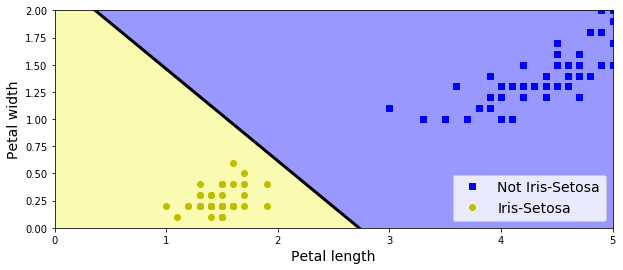

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

事实上，`Perceptron()` 相当于
```python
SGDClassifier(loss="perceptron", learning_rate="constant", eta0=1, penalty=None)
```

感知机的缺点：
- 判定边界（decision boundary）是线性的，所以感知机不能处理非线性的问题（著名的例子：感知机不能处理逻辑异或）
- 不能对每个所属类算出一个概率（这使得我们更倾向于使用Logisitic回归）

解决办法：引入多层感知机（Multi-Layer Perceptron, MLP)

## 1.3 多层感知机与反向传播（Back propagation）

MLP的结构：
- 输入层（input layer）
- 隐藏层（hidden layer）
- 输出层（output layer）

每层都可由多单个或多个LTU组成。除了输出层外每层都有一个bias neuron。当一个ANN有 $\geq 2$ 个隐藏层的时候就称为深度神经网络（DNN）

![MLP](./images/ann/MLP.png)

1986年，D.E.Rumelhart et al.发表了一篇文章，介绍了反向传播算法，可以用来训练MLP，其基本思想是：

> for each training instance the backpropagation algorithm first makes a prediction (forward pass), measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally slightly tweaks the connection weights to reduce the error (Gradient
Descent step).

- 前向传播：一层层的计算神经元直到最后的输出层
- 反向传播：测量误差，测量每个权重对误差的贡献程度
- 梯度下降：更新权值，减小误差

### 激活函数

为了使梯度下降算法可行，不能使用原先的step function，必须改变激活函数：

- **Sigmoid函数**（最常用）：$\sigma(z) = \dfrac{1}{1 + \exp(-z)}$
- 双曲正切函数：$\tanh(z) = 2\sigma(2z) - 1$
- ReLU函数：$\text{ReLU}(z) = \max (0,z)$

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

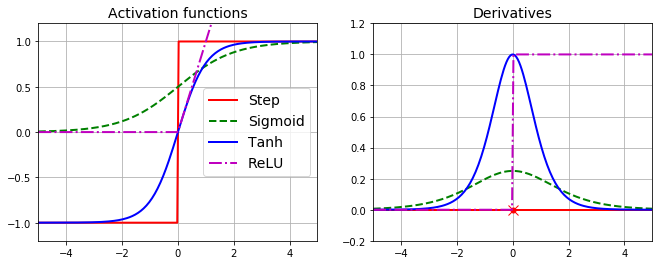

In [7]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

MLP通常用来做分类问题，每个输出对应着一个类别。这时输出层需要做一些改变，原来每个单独的激活函数替换成一个整体的Softmax函数，这样每个输出就是对应于每个类别的概率。

![MLP_classification](./images/ann/MLP_classification.png)

额外的参考资料：

- [A Step by Step Backpropagation Example](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

# 2. 利用TensorFlow的高级API训练MLP

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
X_train = mnist.train.images
X_test = mnist.test.images
y_train = mnist.train.labels.astype("int")
y_test = mnist.test.labels.astype("int")

In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.WARN)

config = tf.contrib.learn.RunConfig(tf_random_seed=42) # not shown in the config

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf = tf.contrib.learn.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                         feature_columns=feature_cols, config=config)
dnn_clf = tf.contrib.learn.SKCompat(dnn_clf) # if TensorFlow >= 1.1
dnn_clf.fit(X_train, y_train, batch_size=50, steps=40000)

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
Please switch to the Estimator interface.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.


SKCompat()

In [7]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test)
accuracy_score(y_test, y_pred['classes'])

0.98270000000000002

书上用的是 `tf.examples.tutorials.mnist` 和 `tf.contrib.learn`，现在这两个API已经不鼓励使用了（deprecated）。所以这里采用作者在GitHub上维护的新版例子。

In [8]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns=feature_cols)

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=40, batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

10027008/11490434 [=========================>....] - ETA: 4:28

Exception: URL fetch failure on https://s3.amazonaws.com/img-datasets/mnist.npz: None -- retrieval incomplete: got only 10026613 out of 11490434 bytes

# 3. 使用plain TensorFlow训练DNN

目标：建立一个深度神经网络实现MNIST的多分类任务

结构：
- 输入：MNIST image，28*28
- 隐藏层1：300个神经元
- 隐藏层2：100个神经元
- 输出：对应10个类别的概率

In [17]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/MNIST_DNN-{}/".format(root_logdir, now)

## 3.1 构建阶段

### 基本数据

In [9]:
import tensorflow as tf

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

### 输入输出层

由于目前还不知道一个batch有多少个实例，所以输入和输出节点的shape设为None

In [10]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

### 隐藏层

In [11]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        z = tf.matmul(X, W) + b
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

- `W`：权重矩阵
 - 用截断(truncated)正态分布初始化，避免出现太大的初始权重（太大的初始权重会减慢收敛速度）
 - 标准差为 $2/ \sqrt{n_{\text{inputs}}}$可以加快算法收敛速度(详见第11章）
- `b`：偏差
- `z`：加权求和的结果

### 建立DNN

In [12]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, n_outputs, "outputs")

- `logits`是神经网络在通过softmax之前的输出

实际上tensorflow提供了一系列函数用于建立神经元层，例如 `fully_connected()` 建立一个全连接层。利用这个函数可将上述代码修改为：
```python
from tensorflow.contrib.layers import fully_connected

with tf.name_scope("dnn"):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(X, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs",
                            activation_fn=None)
```

### cost function

像第四章的Softmax Regression一样，采用交叉熵（corss entropy）来构造代价函数。

In [13]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

### 梯度下降

In [14]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

### 模型评估

用top-1误差率计算准确率来评估

In [15]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### 初始化与模型保存

In [16]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
accuracy_summary = tf.summary.scalar('accuracy', accuracy)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

## 3.2 执行阶段

In [19]:
from tensorflow.examples.tutorials.mnist import input_data
minst = input_data.read_data_sets("/tmp/data/")

n_epochs = 40
batch_size = 50

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [21]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        batch_index = 0
        n_batches = len(X_train) // batch_size
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            batch_index += 1
            if batch_index % 10 == 0:
                # 每10个mini-batches写一次summary
                summary_str = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./final_model/MNSIT_DNN.ckpt")

0 Train accuracy: 0.96 Val accuracy: 0.914
1 Train accuracy: 0.98 Val accuracy: 0.932
2 Train accuracy: 0.98 Val accuracy: 0.94
3 Train accuracy: 0.92 Val accuracy: 0.9488
4 Train accuracy: 0.98 Val accuracy: 0.9518
5 Train accuracy: 0.98 Val accuracy: 0.9564
6 Train accuracy: 0.96 Val accuracy: 0.9602
7 Train accuracy: 0.96 Val accuracy: 0.9612
8 Train accuracy: 0.98 Val accuracy: 0.9634
9 Train accuracy: 0.98 Val accuracy: 0.9632
10 Train accuracy: 0.98 Val accuracy: 0.9668
11 Train accuracy: 0.92 Val accuracy: 0.9672
12 Train accuracy: 1.0 Val accuracy: 0.9674
13 Train accuracy: 0.98 Val accuracy: 0.9694
14 Train accuracy: 0.98 Val accuracy: 0.9702
15 Train accuracy: 1.0 Val accuracy: 0.971
16 Train accuracy: 1.0 Val accuracy: 0.9716
17 Train accuracy: 0.96 Val accuracy: 0.971
18 Train accuracy: 1.0 Val accuracy: 0.9718
19 Train accuracy: 1.0 Val accuracy: 0.974
20 Train accuracy: 1.0 Val accuracy: 0.973
21 Train accuracy: 0.98 Val accuracy: 0.9742
22 Train accuracy: 1.0 Val accurac

## 3.3 可视化

![DNN_MNIST](./images/ann/DNN_MNIST.png)